# UPC Quantum Engineering Final Project: Quantum Channel Discrimination
## II. One-shot discrimination Base circuit

In [4]:
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib inline

from itertools import product, combinations
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
from qiskit import Aer, execute
from numpy import pi
from math import e
import matplotlib.pyplot as plt
import numpy as np
import math

# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

## Functions definition

In [5]:
def prepareInitialStates(inAnglesTheta, inAnglesPhase):
    """ Prepare initial states to pass through the circuit """
    # As we have to provide the state values to initialize the qreg[0] we have to do a conversion
    # from angles in the sphere to statevector amplitudes. These statevectors will be the combination of
    # Zero_Amplitude*|0> plus One_Amplitude*|1>
    initialStatesZeroAmplitude = []
    initialStatesOneAmplitude = []

    for theta in inAnglesTheta:
        for phase in inAnglesPhase:
            initialStatesZeroAmplitude.append(math.cos(theta/2))
            initialStatesOneAmplitude.append(math.sin(theta/2)*e**(1j*phase))
    # List of Initial States
            # print("State ", indexTheta*P+indexPhase," =", initialStatesZeroAmplitude[indexTheta*P+indexPhase],"*|0> + ", initialStatesOneAmplitude     [indexTheta*P   +indexPhase], "*|1>")
    return {
        "zeroAmplitude": initialStatesZeroAmplitude,
        "oneAmplitude": initialStatesOneAmplitude,
    }

In [6]:
def convertCountsToFinalState(inCounts):
    """ Convert the results of a simulation to a final state: aplha*|0> + beta*|1> """
    countsZero = 0
    countsOne = 0

    if "0" in inCounts:
        countsZero = inCounts["0"]
    if "1" in inCounts:
        countsOne = inCounts["1"]

    totalCycles = countsZero + countsOne
    
    return {
        "zeroAmplitude": np.sqrt(countsZero/totalCycles),
        "oneAmplitude": np.sqrt(countsOne/totalCycles),
    }

In [7]:
def computeStateVectorCoordsReshaped(amplitudesVector, inputAnglesPhase, nPointsTheta, nPointsPhase):
    """ Compute the reshaped coordinates from a given amplitudes """
    initialStateVectorCoordsX = []
    initialStateVectorCoordsY = []
    initialStateVectorCoordsZ = []
    for indexAmplitudes in range(len(amplitudesVector)):
        Theta_i = 2*np.arccos(amplitudesVector[indexAmplitudes])
        Phase_i = inputAnglesPhase[indexAmplitudes % nPointsPhase]
        initialStateVectorCoordsX.append(np.sin(Theta_i)*np.cos(Phase_i))
        initialStateVectorCoordsY.append(np.sin(Theta_i)*np.sin(Phase_i))
        initialStateVectorCoordsZ.append(np.cos(Theta_i))
    # Reshaping matrices X, Y and Z in right dimensions to be represented
    return {
        'reshapedCoordsX':  np.reshape(initialStateVectorCoordsX, (nPointsTheta, nPointsPhase)),
        'reshapedCoordsY':  np.reshape(initialStateVectorCoordsY, (nPointsTheta, nPointsPhase)),
        'reshapedCoordsZ':  np.reshape(initialStateVectorCoordsZ, (nPointsTheta, nPointsPhase)),
    }

In [8]:
def computeFinaleStateVectorCoordsReshaped(amplitudesVector, inputAnglesPhase, nPointsTheta, nPointsPhase):
    """ Compute the final state reshaped coordinates from a given amplitudes """
    finalStateVectorCoordsX = []
    finalStateVectorCoordsY = []
    finalStateVectorCoordsZ = []
    for indexAmplitudes in range(len(amplitudesVector)):
        Theta_i = 2*np.arccos(amplitudesVector[indexAmplitudes])
        Phase_i = inputAnglesPhase[indexAmplitudes % nPointsPhase]
        finalStateVectorCoordsZ.append(np.cos(Theta_i))
    # Reshaping matrices X, Y and Z in right dimensions to be represented
    top_z = max(finalStateVectorCoordsZ)
    min_z = min(finalStateVectorCoordsZ)
    radius = (top_z-min_z)/2
    center_z = 1-radius

    for newIndexAmplitudes in range(len(amplitudesVector)):
        newTheta_i = np.arccos((finalStateVectorCoordsZ[newIndexAmplitudes]-center_z)/radius)
        newPhase_i = inputAnglesPhase[newIndexAmplitudes % nPointsPhase]
        finalStateVectorCoordsX.append(np.sqrt(radius)*np.sin(newTheta_i)*np.cos(newPhase_i))
        finalStateVectorCoordsY.append(np.sqrt(radius)*np.sin(newTheta_i)*np.sin(newPhase_i))
    return {
        'reshapedCoordsX':  np.reshape(finalStateVectorCoordsX, (nPointsTheta, nPointsPhase)),
        'reshapedCoordsY':  np.reshape(finalStateVectorCoordsY, (nPointsTheta, nPointsPhase)),
        'reshapedCoordsZ':  np.reshape(finalStateVectorCoordsZ, (nPointsTheta, nPointsPhase)),
        'center': center_z
    }

In [9]:
def draw_cube(axes):
    """ Draw a cube passing axes as a parameter """
    r = [-1, 1]
    for s, e in combinations(np.array(list(product(r, r, r))), 2):
        if np.sum(np.abs(s-e)) == r[1]-r[0]:
            axes.plot3D(*zip(s, e), color="w")

## Circuit definition and computation

In [10]:
def runDampingChannelSimulation(anglesEta, pointsTheta, pointsPhase, iterations, backend):
    # Create 2 qbits circuit and 1 output classical bit
    qreg_q = QuantumRegister(2, 'q')
    creg_c = ClassicalRegister(1, 'c')
    # First we generate the angles which will help the draw the sphere
    anglesTheta = np.mgrid[0:pi:pointsTheta*1j]
    anglesPhase = np.mgrid[0:2*pi:pointsPhase*1j]

    totalResults = []
    totalCounts = []
    totalCircuits = []
    totalFinalStates = []

    initialStates = prepareInitialStates(anglesTheta, anglesPhase)

    # Initialize circuit with desired initial_state
    for eta in anglesEta:
        print("Simulating channel with " + u"\u03B7" + " = " + str(int(math.degrees(eta)))  + u"\u00B0")
        circuitResultsSpecificChannel = []
        countsSpecificChannel = []
        circuitSpecificChannel = []
        finalStates = {
            "zeroAmplitude": [],
            "oneAmplitude": [],
        }
        for indexInitialState in range(len(initialStates["zeroAmplitude"])):
            circuit = QuantumCircuit(qreg_q, creg_c)
            circuit.initialize([initialStates["zeroAmplitude"][indexInitialState], initialStates["oneAmplitude"][indexInitialState]], qreg_q[0])

            circuit.reset(qreg_q[1])
            circuit.cry(eta, qreg_q[0], qreg_q[1])
            circuit.cx(qreg_q[1], qreg_q[0])
            circuit.measure(qreg_q[0], creg_c[0])
            circuitSpecificChannel.append(circuit)
            # execute circuit on backends
            job_sim = execute(circuit, backend, shots=iterations)
            # get results
            results_sim = job_sim.result()
            circuitResultsSpecificChannel.append(results_sim)
            counts = results_sim.get_counts(circuit)
            countsSpecificChannel.append(counts)
            finalState = convertCountsToFinalState(counts)
            finalStates["zeroAmplitude"].append(finalState["zeroAmplitude"])
            finalStates["oneAmplitude"].append(finalState["oneAmplitude"])
 
        # append the results for a specific channel
        totalCircuits.append(circuitSpecificChannel)
        totalFinalStates.append(finalStates)
        totalCounts.append(countsSpecificChannel)
        totalResults.append(circuitResultsSpecificChannel)
    return {
        "initialStates": initialStates,
        "totalCircuits": totalCircuits,
        "totalFinalStates": totalFinalStates,
        "totalCounts": totalCounts,
        "totalResults": totalResults,
        "anglesPhase": anglesPhase
    }


In [11]:
pointsTheta = 10  # Points of Theta angle (pi) in Bloch sphere - min 2
pointsPhase = 20  # Points of Phase angle (2*pi) in Bloch sphere - min 2
# angles shift from first parameter, to the second one, with jumps using the third parameter
anglesEta = np.arange(0, 2*pi, 2*pi/16)
# anglesEta = [0, pi/4, pi/1.5, pi/1.09]
simulatedResult = runDampingChannelSimulation(anglesEta=anglesEta , pointsTheta=pointsTheta, pointsPhase=pointsPhase, iterations=1024, backend=backend_sim)
initialStates = simulatedResult["initialStates"]
totalResults = simulatedResult["totalResults"]
totalCounts = simulatedResult["totalCounts"]
totalCircuits = simulatedResult["totalCircuits"]
totalFinalStates = simulatedResult["totalFinalStates"]
anglesPhase = simulatedResult["anglesPhase"]

Simulating channel with η = 0°
Simulating channel with η = 22°
Simulating channel with η = 45°
Simulating channel with η = 67°
Simulating channel with η = 90°
Simulating channel with η = 112°
Simulating channel with η = 135°
Simulating channel with η = 157°
Simulating channel with η = 180°
Simulating channel with η = 202°
Simulating channel with η = 225°
Simulating channel with η = 247°
Simulating channel with η = 270°
Simulating channel with η = 292°
Simulating channel with η = 315°
Simulating channel with η = 337°


In [12]:
from qiskit.providers.ibmq import least_busy
from qiskit import IBMQ
# provider = IBMQ.load_account()
# Load IBM Q account and get the least busy backend device
# least_busy_device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2, simulator=False))
# print("Running on current least busy device: ", least_busy_device)

In [10]:
# pointsTheta = 4  # Points of Theta angle (pi) in Bloch sphere - min 2
# pointsPhase = 4  # Points of Phase angle (2*pi) in Bloch sphere - min 2
# angles shift from first parameter, to the second one, with jumps using the third parameter
# anglesEta = np.arange(0, 2*pi, 2*pi/6)
# anglesEta = [pi/1.5]
# realResult = runDampingChannelSimulation(anglesEta=anglesEta , pointsTheta=pointsTheta, pointsPhase=pointsPhase, iterations=1024, backend=least_busy_device)
# initialStates = realResult["initialStates"]
# totalResults = realResult["totalResults"]
# totalCounts = realResult["totalCounts"]
# totalCircuits = realResult["totalCircuits"]
# totalFinalStates = realResult["totalFinalStates"]

In [13]:
# Set the Initial States
initialStatesReshaped = computeStateVectorCoordsReshaped(initialStates["zeroAmplitude"], anglesPhase, pointsTheta, pointsPhase)
# Set the Final States
allChannelsFinalStatesReshaped = []
for indexFinalState in range(len(totalFinalStates)):
    singleChannelFinalStatesReshaped = computeFinaleStateVectorCoordsReshaped(totalFinalStates[indexFinalState]["zeroAmplitude"], anglesPhase, pointsTheta, pointsPhase)
    allChannelsFinalStatesReshaped.append(singleChannelFinalStatesReshaped)


## Plotting the results

### Damping channel for $\eta=\pi/4$

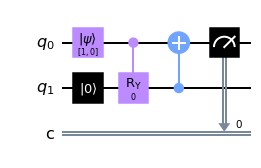

In [14]:
totalCircuits[0][10].draw('mpl')

### Input vs Output Probabilities (WIP)

In [15]:
def probability_from_amplitude(amplitude) -> int:
    return np.round(np.linalg.norm(amplitude) ** 2, 2)

In [17]:
def extract_amplitudes_states(initial_states, final_states, number_execution, output_probabilities):
    total_amplitudes_to_extract = 20
    initial_state_zero_amplitude = "0_input"
    initial_state_one_amplitude = "1_input"
    final_state_zero_amplitude = "0_output"
    final_state_one_amplitude = "1_output"
    zero_amplitude = "zeroAmplitude"
    one_amplitude = "oneAmplitude"
    psi = u"\u03C8"
    
    output_probabilities.append({ 
        initial_state_zero_amplitude: probability_from_amplitude(initial_states[zero_amplitude][0]),
        final_state_zero_amplitude: probability_from_amplitude(final_states[number_execution][zero_amplitude][0]),
        initial_state_one_amplitude: probability_from_amplitude(initial_states[one_amplitude][0]),
        final_state_one_amplitude: probability_from_amplitude(final_states[number_execution][one_amplitude][0])
    })

    for index in range(2,total_amplitudes_to_extract):
        index_state = int((len(final_states[number_execution][zero_amplitude])/total_amplitudes_to_extract)*index)
        output_probabilities.append({ 
            initial_state_zero_amplitude: probability_from_amplitude(initial_states[zero_amplitude][index_state]),
            final_state_zero_amplitude: probability_from_amplitude(final_states[number_execution][zero_amplitude][index_state]),
            initial_state_one_amplitude: probability_from_amplitude(initial_states[one_amplitude][index_state]),
            final_state_one_amplitude: probability_from_amplitude(final_states[number_execution][one_amplitude][index_state])
        })
    
    final_index_state = int((len(final_states[number_execution][zero_amplitude])/total_amplitudes_to_extract)*total_amplitudes_to_extract)-1
    output_probabilities.append({ 
        initial_state_zero_amplitude: probability_from_amplitude(initial_states[zero_amplitude][final_index_state]),
        final_state_zero_amplitude: probability_from_amplitude(final_states[number_execution][zero_amplitude][final_index_state]),
        initial_state_one_amplitude: probability_from_amplitude(initial_states[one_amplitude][final_index_state]),
        final_state_one_amplitude: probability_from_amplitude(final_states[number_execution][one_amplitude][final_index_state])
    })
    return output_probabilities

In [18]:
# set the counts execution to print
# indexCountsToPrint = 0

total_output_probabilities = []
for indexCountsToPrint in range(len(anglesEta)):
    output_probabilities = []
    output_probabilities = extract_amplitudes_states(initialStates, totalFinalStates, indexCountsToPrint, output_probabilities)
    total_output_probabilities.append(output_probabilities)

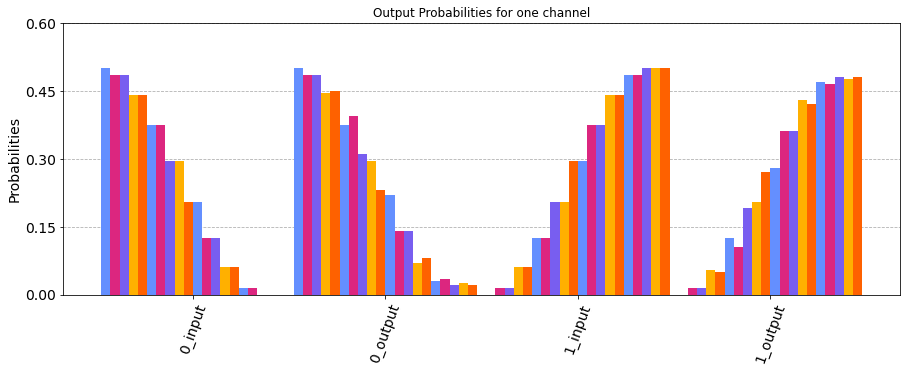

In [19]:

display(plot_histogram(output_probabilities, title="Output Probabilities for one channel", figsize=(15, 5), bar_labels=False, sort='asc'))

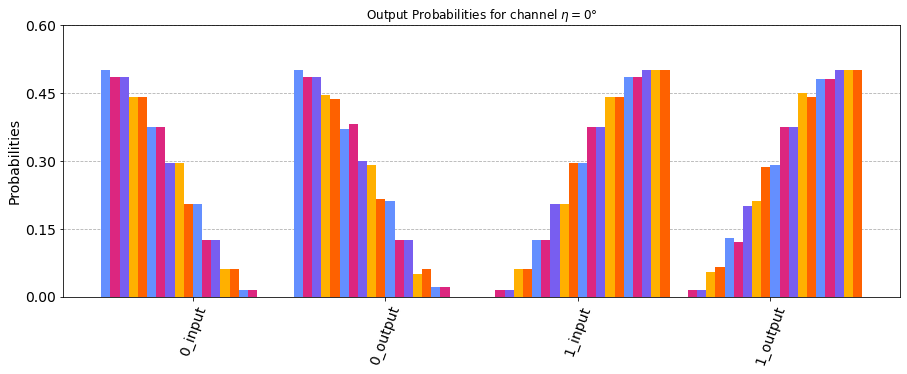

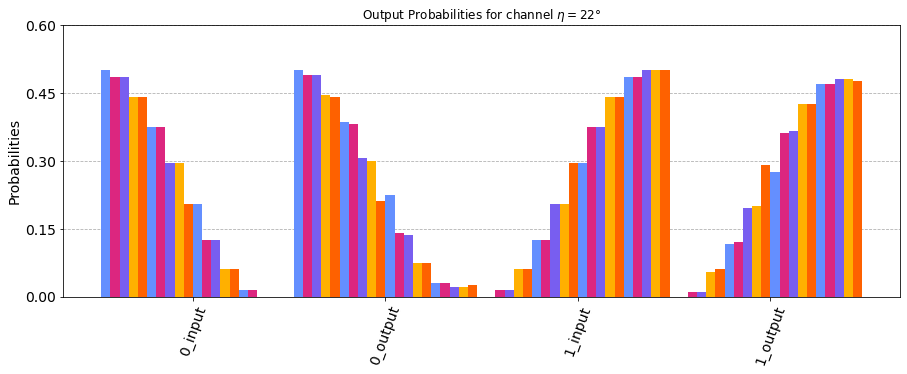

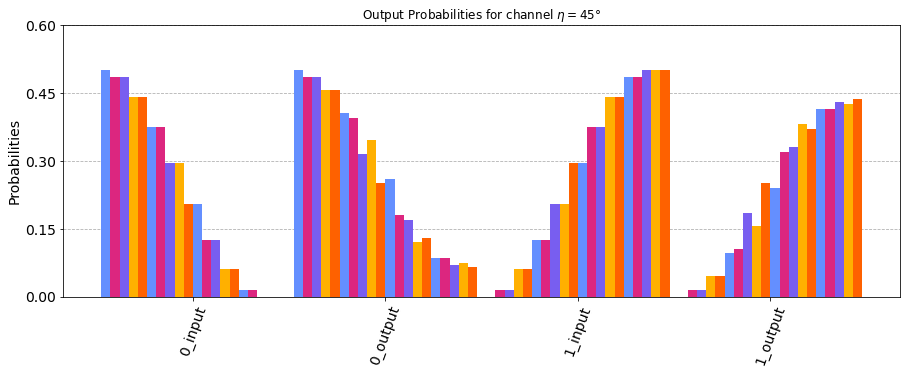

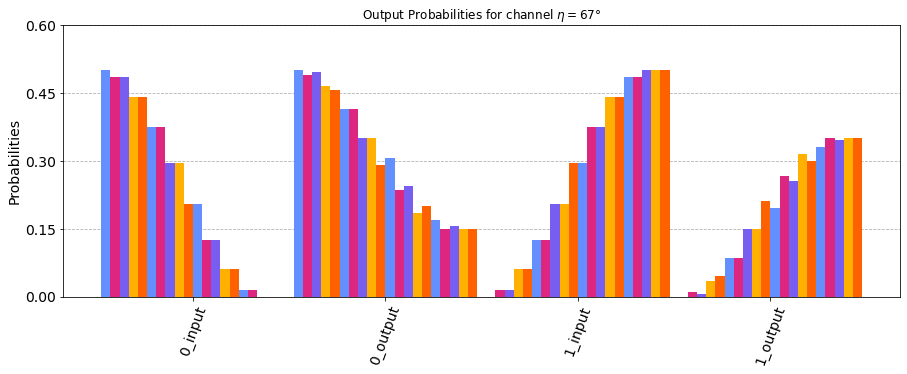

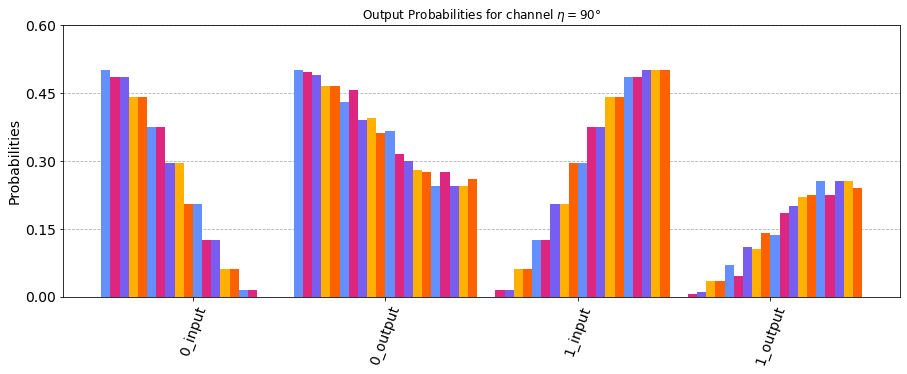

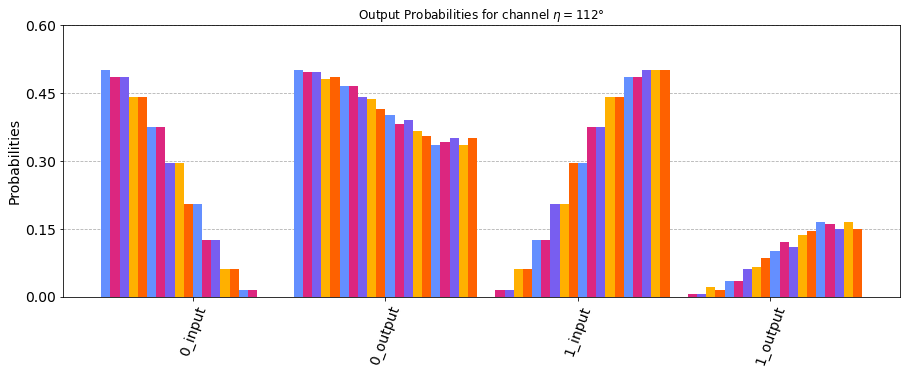

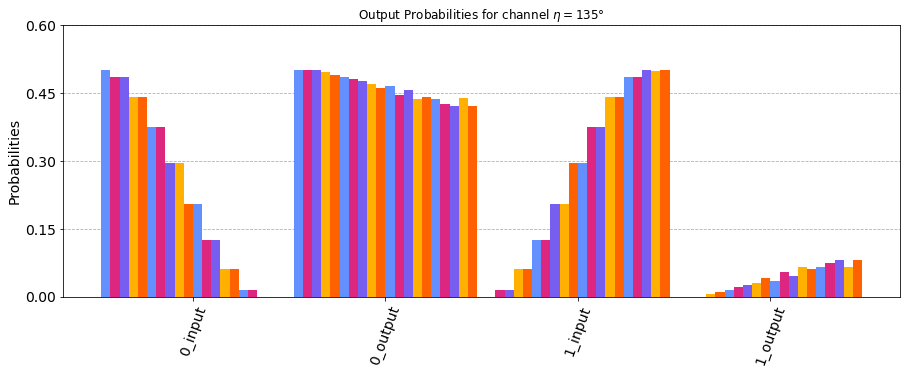

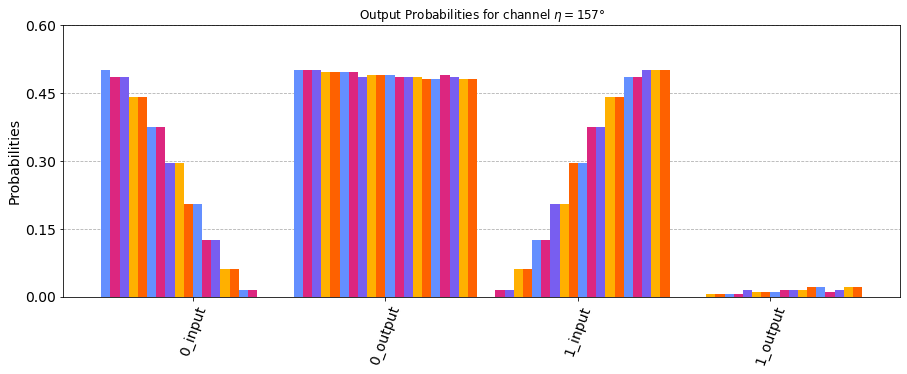

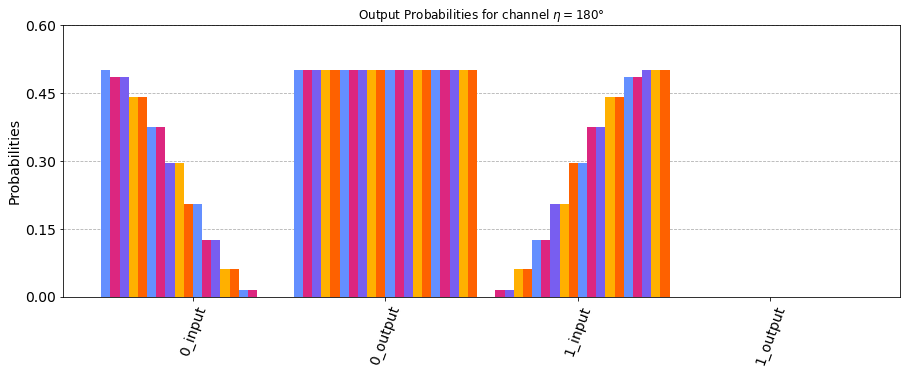

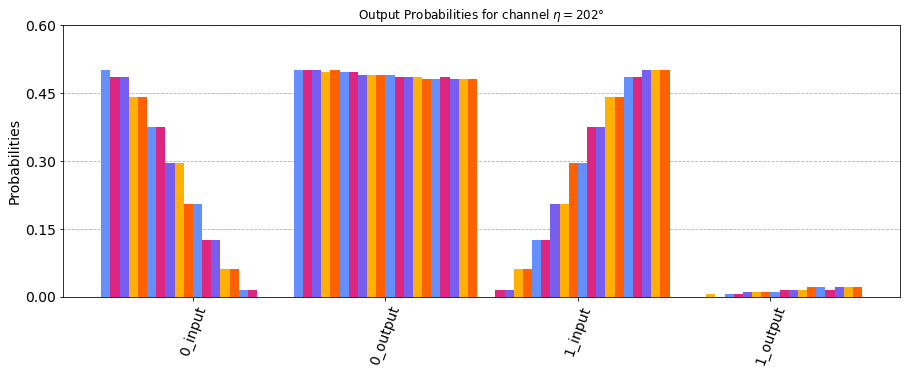

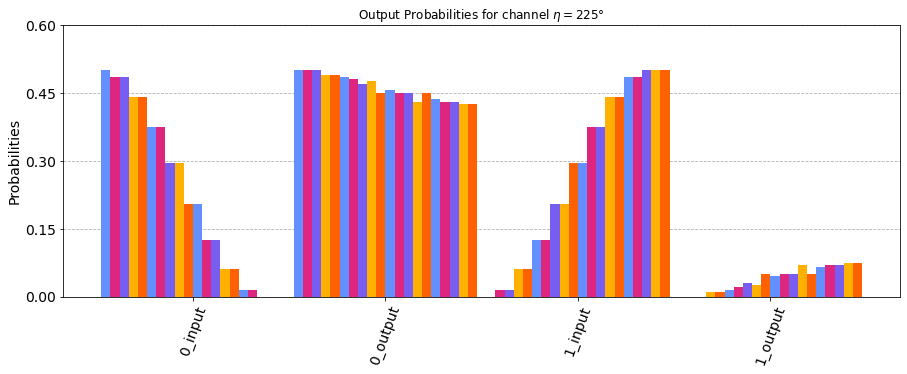

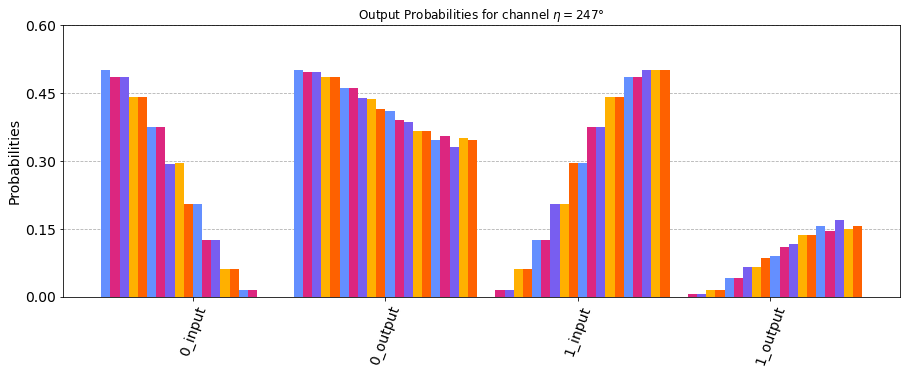

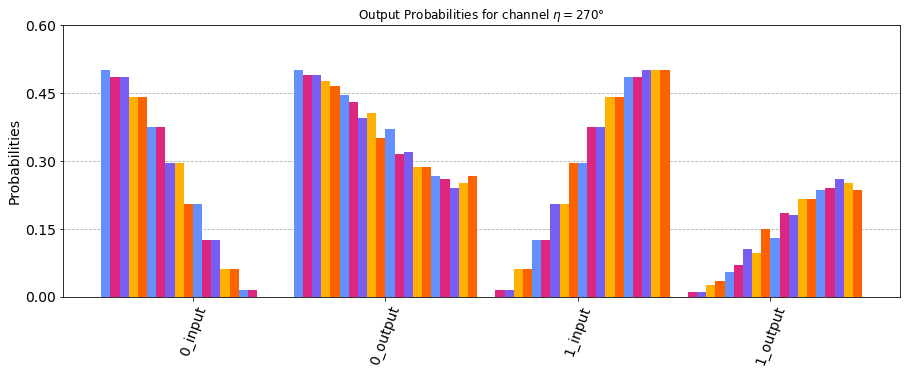

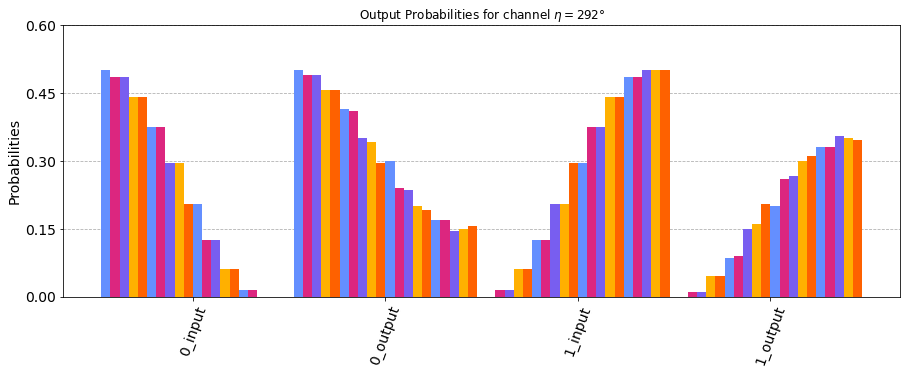

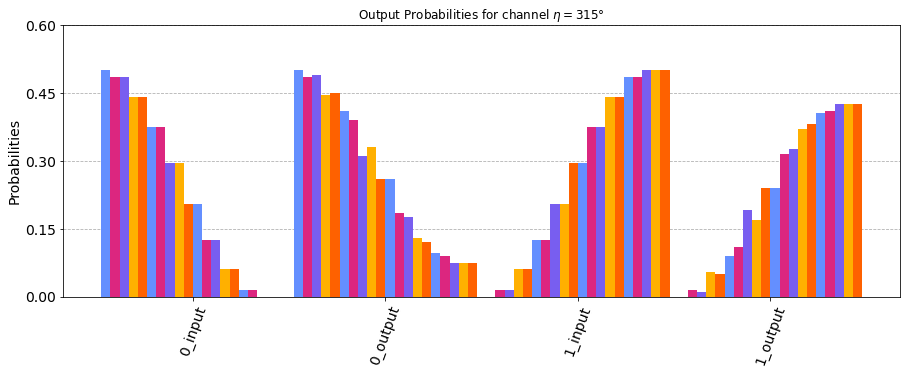

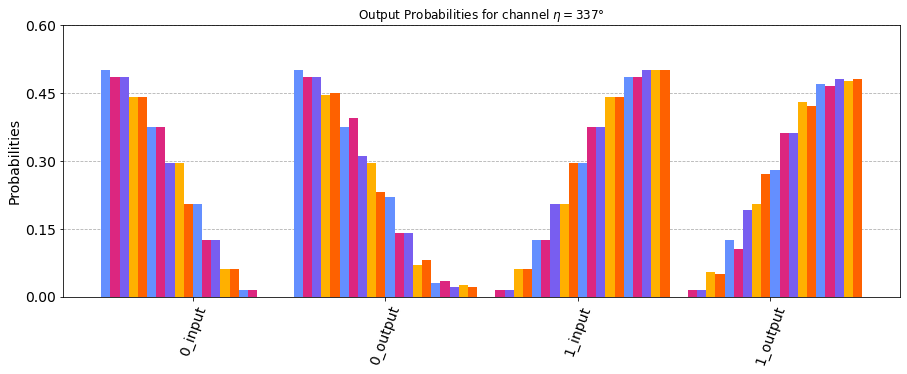

In [20]:
for index_output in range(len(anglesEta)):
    display(plot_histogram(total_output_probabilities[index_output], title="Output Probabilities for channel " + "$\eta=" + str(int(math.degrees(anglesEta[index_output]))) + "\degree$", figsize=(15, 5), bar_labels=False, sort='asc'))

### Fidelity of our damping channel for $\eta=\pi/4$

In [14]:
# TODO

### Plotting both Initial States and Final States for all simulated 16 channels

In [21]:
def plotChannelsBlochs():
    fig = plt.figure(figsize=(20,25))
    #===============
    #  First subplot
    #===============
    # set up the axes for the first plot
    ax = fig.add_subplot(5, 4, 1, projection='3d')
    draw_cube(ax)

    # draw initial states
    ax.plot_wireframe(initialStatesReshaped['reshapedCoordsX'], initialStatesReshaped['reshapedCoordsY'], initialStatesReshaped['reshapedCoordsZ'], color="c")
    ax.set_title("Initial States")
    # draw center
    ax.scatter([0], [0], [0], color="g", s=50)

    #===============
    # Next subplots
    #===============

    indexFinalStateReshaped = 0
    for finalStatesReshaped in allChannelsFinalStatesReshaped:
        # set up the axes for the second plot
        ax = fig.add_subplot(5, 4, 2 + indexFinalStateReshaped, projection='3d')
        draw_cube(ax)
        # draw final states
        ax.plot_wireframe(finalStatesReshaped['reshapedCoordsX'], finalStatesReshaped['reshapedCoordsY'], finalStatesReshaped['reshapedCoordsZ'], color="r")
        title = "Final States\n Channel " + "$\eta=" + str(int(math.degrees(anglesEta[indexFinalStateReshaped]))) + "\degree$"
        ax.set_title(title)
        # draw center
        ax.scatter([0], [0], finalStatesReshaped["center"], color="g", s=50)
        indexFinalStateReshaped+=1



    display(plt.show())

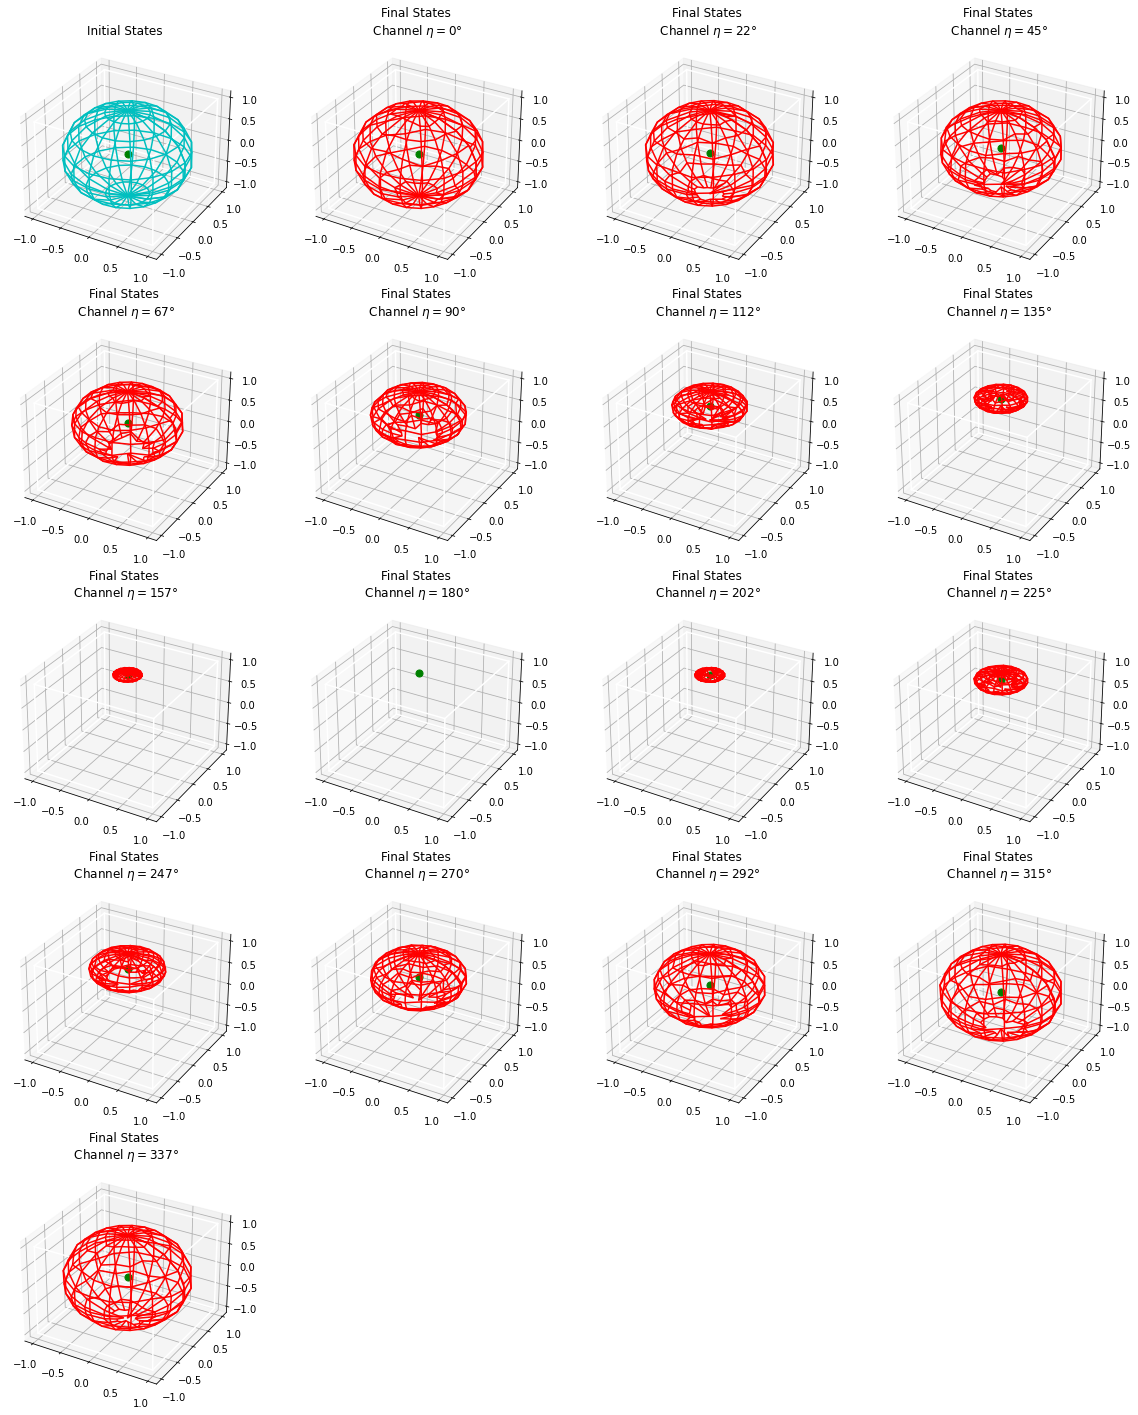

None

In [22]:
plotChannelsBlochs()

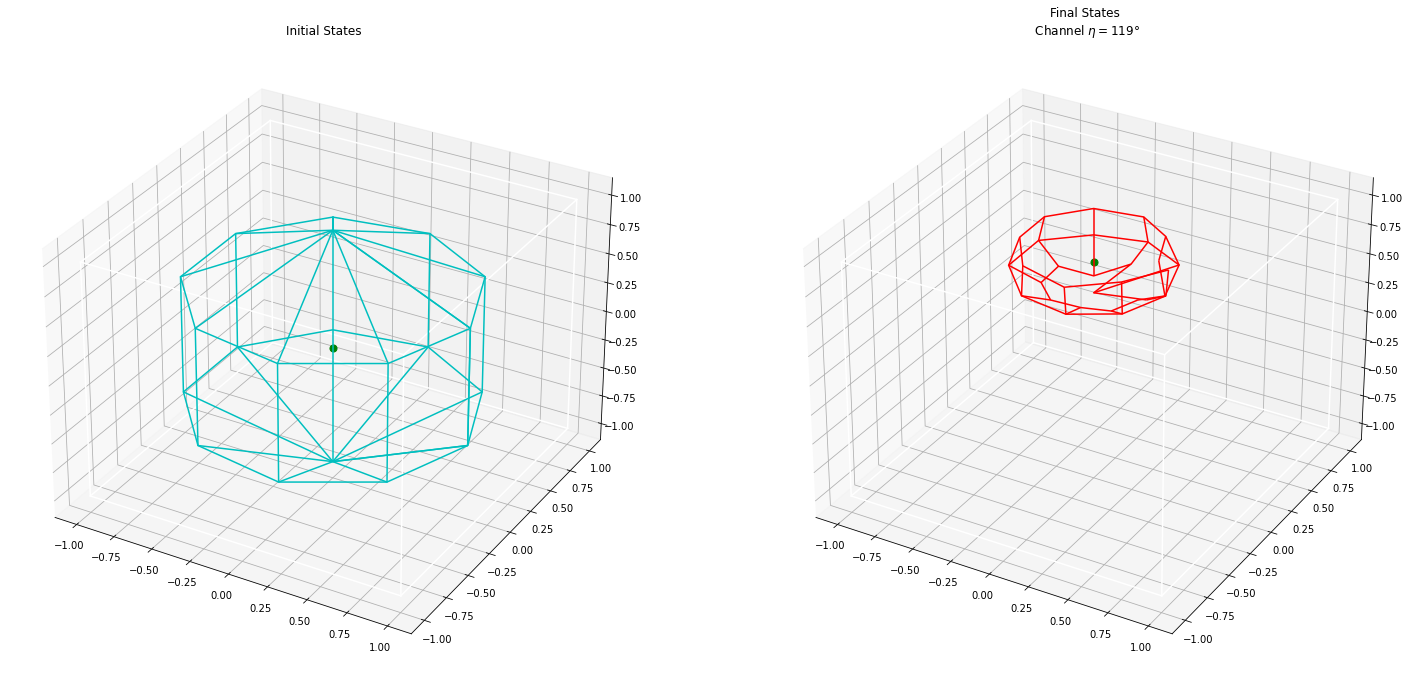

None

In [18]:
plotChannelsBlochs()